## IV -Merge all DBs & apply Logistic Regression
#### 1) Importing libraries

In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
%matplotlib inline 
print("Imported all the required libraries")

Imported all the required libraries


In [2]:
sql1 = """
SELECT * FROM "READM_30_AMI_HRRP" ;"""
sql2 = """
SELECT * FROM "READM_30_CABG_HRRP" ;"""
sql3 = """
SELECT * FROM "READM_30_COPD_HRRP" ;"""
sql4 = """
SELECT * FROM "READM_30_HF_HRRP" ;"""
sql5 = """
SELECT * FROM "READM_30_HIP_KNEE_HRRP" ;"""
sql6 = """
SELECT * FROM "READM_30_PN_HRRP" ;"""
sql7 = """
SELECT * FROM "HACRP" ;"""
sql8 = """
SELECT * FROM "HVBP" ;"""

try:
    dbConnection = psycopg2.connect(
    user = "dap",
    password = "dap",
    host = "83.212.82.56",
    port = "5432",
    database = "dap_medicare")
    ami_df = sqlio.read_sql_query(sql1, dbConnection) 
    cabg_df = sqlio.read_sql_query(sql2, dbConnection) 
    copd_df = sqlio.read_sql_query(sql3, dbConnection) 
    hf_df = sqlio.read_sql_query(sql4, dbConnection) 
    hip_df = sqlio.read_sql_query(sql5, dbConnection) 
    pn_df = sqlio.read_sql_query(sql6, dbConnection)
    hacrp_df = sqlio.read_sql_query(sql7, dbConnection)
    hvbp_df = sqlio.read_sql_query(sql8, dbConnection)
except (Exception, psycopg2.Error) as dbError:
    print ("Error while fetching database", dbError)
finally:
    if(dbConnection): dbConnection.close()

#### 2) Transforming dataframes before merging

In [3]:
hacrp_df.head()

,provider_id,hospital_name,state,fiscal_year,psi_90__start_date,psi_90_end_date,psi_90_w_z_score,clabsi_w_z_score,cauti_w_z_score,ssi_w_z_score,mrsa_w_z_score,cdi_w_z_score,hai_measures_start_date,hai_measures_end_date,total_hac_score,payment_reduction
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,2020,2016-07-01,2018-06-30,0.0144,1.03250,0.11600,-1.24030,-0.55330,-0.4571,2017-01-01,2018-12-31,-0.1813,No
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,2020,2016-07-01,2018-06-30,0.1869,2.19410,-0.14060,-0.16810,2.25020,-0.6434,2017-01-01,2018-12-31,0.6132,Yes
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,2020,2016-07-01,2018-06-30,0.2308,0.32630,0.77920,-0.65080,0.83250,-0.7786,2017-01-01,2018-12-31,0.1232,No
3,10007,MIZELL MEMORIAL HOSPITAL,AL,2020,2016-07-01,2018-06-30,-0.0548,-0.85836,-1.53540,-0.28418,0.18616,-0.7877,2017-01-01,2018-12-31,-0.7926,No
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,2020,2016-07-01,2018-06-30,-0.0047,0.68718,0.00424,0.24306,0.04848,-0.7384,2017-01-01,2018-12-31,-0.0047,No


In [4]:
hacrp_df = hacrp_df[['provider_id','total_hac_score','payment_reduction']]
hacrp_df.head()

,provider_id,total_hac_score,payment_reduction
0,10001,-0.1813,No
1,10005,0.6132,Yes
2,10006,0.1232,No
3,10007,-0.7926,No
4,10008,-0.0047,No


In [5]:
hvbp_df.head()

,provider_number,hospital_name,address,city,state,zip_code,county_name,mort_30_ami_achievement_threshold,mort_30_ami_benchmark,mort_30_ami_baseline_rate,...,mort_30_pn_measure_score,comp_hip_knee_achievement_threshold,comp_hip_knee_benchmark,comp_hip_knee_baseline_rate,comp_hip_knee_performance_rate,comp_hip_knee_achievement_points,comp_hip_knee_improvement_points,comp_hip_knee_measure_score,latitude,longitude
0,50026,GROSSMONT HOSPITAL,5555 GROSSMONT CENTER DRIVE BOX 58,LA MESA,CA,91942,San Diego,0.853715,0.875869,0.837234,...,9,0.032229,0.023178,0.027022,0.018553,10,9,10,32.779435,-117.009178
1,50103,WHITE MEMORIAL MEDICAL CENTER,1720 E CESAR AVENUE,LOS ANGELES,CA,90033,Los Angeles,0.853715,0.875869,0.862837,...,10,0.032229,0.023178,0.034845,0.020537,10,9,10,NaN,NaN
2,50224,HOAG MEMORIAL HOSPITAL PRESBYTERIAN,ONE HOAG DRIVE,NEWPORT BEACH,CA,92663,Orange,0.853715,0.875869,0.856289,...,10,0.032229,0.023178,0.037973,0.026753,7,8,7,NaN,NaN
3,60020,"PARKVIEW MEDICAL CENTER, INC",400 W 16TH ST,PUEBLO,CO,81003,Pueblo,0.853715,0.875869,0.856647,...,8,0.032229,0.023178,0.037675,0.038362,0,0,0,38.281678,-104.612123
4,150169,COMMUNITY HOSPITAL NORTH,7150 CLEARVISTA DR,INDIANAPOLIS,IN,46256,Marion,0.853715,0.875869,0.827037,...,3,0.032229,0.023178,0.032862,0.031087,2,1,2,39.900033,-86.043072


In [6]:
features = ["provider_number","mort_30_ami_achievement_points","mort_30_ami_improvement_points","mort_30_ami_measure_score","mort_30_hf_achievement_points","mort_30_hf_improvement_points","mort_30_hf_measure_score","mort_30_pn_achievement_points","mort_30_pn_improvement_points","mort_30_pn_measure_score","comp_hip_knee_achievement_points","comp_hip_knee_improvement_points","comp_hip_knee_measure_score"]
hvbp_df = hvbp_df[features]
hvbp_df = hvbp_df.rename(columns={"provider_number":"provider_id"})
hvbp_df.head()

,provider_id,mort_30_ami_achievement_points,mort_30_ami_improvement_points,mort_30_ami_measure_score,mort_30_hf_achievement_points,mort_30_hf_improvement_points,mort_30_hf_measure_score,mort_30_pn_achievement_points,mort_30_pn_improvement_points,mort_30_pn_measure_score,comp_hip_knee_achievement_points,comp_hip_knee_improvement_points,comp_hip_knee_measure_score
0,50026,8,8,8,10,9,10,9,9,9,10,9,10
1,50103,10,9,10,9,0,9,10,9,10,10,9,10
2,50224,10,9,10,10,9,10,10,9,10,7,8,7
3,60020,1,0,1,2,5,5,8,4,8,0,0,0
4,150169,1,5,5,0,3,3,3,0,3,2,1,2


In [7]:
ami_df.head()

,provider_id,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,READM-30-AMI-HRRP,742,1.044600,15.293500,14.640400,116,2015-07-01,2018-06-30
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,READM-30-AMI-HRRP,344,0.925500,14.102400,15.237900,44,2015-07-01,2018-06-30
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,READM-30-AMI-HRRP,458,0.967300,13.512200,13.968500,60,2015-07-01,2018-06-30
3,10007,MIZELL MEMORIAL HOSPITAL,AL,READM-30-AMI-HRRP,271,1.001453,15.764015,15.710386,42,2015-07-01,2018-06-30
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,READM-30-AMI-HRRP,271,1.001453,15.764015,15.710386,42,2015-07-01,2018-06-30


In [8]:
ami_df = ami_df[['provider_id','excess_readmission_ratio']]
ami_df = ami_df.rename(columns={"excess_readmission_ratio":"ami_err"})
ami_df.head()

,provider_id,ami_err
0,10001,1.044600
1,10005,0.925500
2,10006,0.967300
3,10007,1.001453
4,10008,1.001453


In [9]:
cabg_df.head()

,provider_id,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,READM-30-CABG-HRRP,279,1.236100,14.594300,11.806500,46,2015-07-01,2018-06-30
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,READM-30-CABG-HRRP,179,1.002192,12.809151,12.771704,24,2015-07-01,2018-06-30
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,READM-30-CABG-HRRP,136,1.009600,12.325400,12.207900,17,2015-07-01,2018-06-30
3,10007,MIZELL MEMORIAL HOSPITAL,AL,READM-30-CABG-HRRP,179,1.002192,12.809151,12.771704,24,2015-07-01,2018-06-30
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,READM-30-CABG-HRRP,179,1.002192,12.809151,12.771704,24,2015-07-01,2018-06-30


In [10]:
cabg_df = cabg_df[['provider_id','excess_readmission_ratio']]
cabg_df = cabg_df.rename(columns={"excess_readmission_ratio":"cabg_err"})
cabg_df.head()

,provider_id,cabg_err
0,10001,1.236100
1,10005,1.002192
2,10006,1.009600
3,10007,1.002192
4,10008,1.002192


In [11]:
copd_df.head()

,provider_id,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,READM-30-COPD-HRRP,495,1.0249,18.6162,18.1637,94,2015-07-01,2018-06-30
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,READM-30-COPD-HRRP,636,0.9028,16.1179,17.8526,95,2015-07-01,2018-06-30
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,READM-30-COPD-HRRP,632,1.0018,17.8584,17.8263,113,2015-07-01,2018-06-30
3,10007,MIZELL MEMORIAL HOSPITAL,AL,READM-30-COPD-HRRP,140,1.0361,18.8096,18.1544,29,2015-07-01,2018-06-30
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,READM-30-COPD-HRRP,123,0.9728,16.2425,16.6962,18,2015-07-01,2018-06-30


In [12]:
copd_df = copd_df[['provider_id','excess_readmission_ratio']]
copd_df = copd_df.rename(columns={"excess_readmission_ratio":"copd_err"})
copd_df.head()

,provider_id,copd_err
0,10001,1.0249
1,10005,0.9028
2,10006,1.0018
3,10007,1.0361
4,10008,0.9728


In [13]:
hf_df.head()

,provider_id,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,READM-30-HF-HRRP,1114,1.045300,22.377200,21.408200,252,2015-07-01,2018-06-30
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,READM-30-HF-HRRP,341,0.991100,20.391700,20.574400,69,2015-07-01,2018-06-30
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,READM-30-HF-HRRP,793,0.946900,19.453900,20.545800,151,2015-07-01,2018-06-30
3,10007,MIZELL MEMORIAL HOSPITAL,AL,READM-30-HF-HRRP,79,1.074400,19.918900,18.538700,20,2015-07-01,2018-06-30
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,READM-30-HF-HRRP,427,1.001901,21.102234,21.042851,92,2015-07-01,2018-06-30


In [14]:
hf_df = hf_df[['provider_id','excess_readmission_ratio']]
hf_df = hf_df.rename(columns={"excess_readmission_ratio":"hf_err"})
hf_df.head()

,provider_id,hf_err
0,10001,1.045300
1,10005,0.991100
2,10006,0.946900
3,10007,1.074400
4,10008,1.001901


In [15]:
hip_df.head()

,provider_id,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,READM-30-HIP-KNEE-HRRP,301,1.178700,5.58630,4.739200,20,2015-07-01,2018-06-30
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,READM-30-HIP-KNEE-HRRP,257,1.023200,4.88770,4.776700,13,2015-07-01,2018-06-30
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,READM-30-HIP-KNEE-HRRP,399,1.184100,4.95780,4.186900,23,2015-07-01,2018-06-30
3,10007,MIZELL MEMORIAL HOSPITAL,AL,READM-30-HIP-KNEE-HRRP,269,1.126800,5.41440,4.805300,17,2015-07-01,2018-06-30
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,READM-30-HIP-KNEE-HRRP,641,1.006649,4.25932,4.223695,26,2015-07-01,2018-06-30


In [16]:
hip_df = hip_df[['provider_id','excess_readmission_ratio']]
hip_df = hip_df.rename(columns={"excess_readmission_ratio":"hip_err"})
hip_df.head()

,provider_id,hip_err
0,10001,1.178700
1,10005,1.023200
2,10006,1.184100
3,10007,1.126800
4,10008,1.006649


In [17]:
pn_df.head()

,provider_id,hospital_name,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,READM-30-PN-HRRP,605,1.0049,16.8059,16.7237,102,2015-07-01,2018-06-30
1,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,AL,READM-30-PN-HRRP,697,0.9833,15.0773,15.3333,104,2015-07-01,2018-06-30
2,10006,NORTH ALABAMA MEDICAL CENTER,AL,READM-30-PN-HRRP,837,0.9827,15.5479,15.8209,129,2015-07-01,2018-06-30
3,10007,MIZELL MEMORIAL HOSPITAL,AL,READM-30-PN-HRRP,211,1.0590,15.3122,14.4590,36,2015-07-01,2018-06-30
4,10008,CRENSHAW COMMUNITY HOSPITAL,AL,READM-30-PN-HRRP,181,0.9610,13.3078,13.8483,22,2015-07-01,2018-06-30


In [18]:
pn_df = pn_df[['provider_id','excess_readmission_ratio']]
pn_df = pn_df.rename(columns={"excess_readmission_ratio":"pn_err"})
pn_df.head()

,provider_id,pn_err
0,10001,1.0049
1,10005,0.9833
2,10006,0.9827
3,10007,1.0590
4,10008,0.9610


#### 3) Merging all the dataframes 

In [19]:
m1 = pd.merge(ami_df, pn_df, on='provider_id', how='inner')
m1.shape

(3224, 3)

In [20]:
m2 = pd.merge(m1, hip_df, on='provider_id', how='inner')
m2.shape

(3224, 4)

In [21]:
m3 = pd.merge(m2, hf_df, on='provider_id', how='inner')
m3.shape

(3224, 5)

In [22]:
m4 = pd.merge(m3, copd_df, on='provider_id', how='inner')
m4.shape

(3224, 6)

In [23]:
m5 = pd.merge(m4, copd_df, on='provider_id', how='inner')
m5.shape

(3224, 7)

In [24]:
m6 = pd.merge(m5, cabg_df, on='provider_id', how='inner')
m6.shape

(3224, 8)

In [25]:
m7 = pd.merge(m6, hvbp_df, on='provider_id', how='inner')
m7.shape

(2729, 20)

In [26]:
medicare_df = pd.merge(m7, hacrp_df, on='provider_id', how='inner')
medicare_df.head()

,provider_id,ami_err,pn_err,hip_err,hf_err,copd_err_x,copd_err_y,cabg_err,mort_30_ami_achievement_points,mort_30_ami_improvement_points,...,mort_30_hf_improvement_points,mort_30_hf_measure_score,mort_30_pn_achievement_points,mort_30_pn_improvement_points,mort_30_pn_measure_score,comp_hip_knee_achievement_points,comp_hip_knee_improvement_points,comp_hip_knee_measure_score,total_hac_score,payment_reduction
0,10001,1.044600,1.0049,1.1787,1.0453,1.0249,1.0249,1.236100,7,0,...,0,0,2,0,2,1,5,5,-0.1813,No
1,10005,0.925500,0.9833,1.0232,0.9911,0.9028,0.9028,1.002192,1,5,...,1,1,0,1,1,9,9,9,0.6132,Yes
2,10006,0.967300,0.9827,1.1841,0.9469,1.0018,1.0018,1.009600,0,4,...,3,3,0,5,5,8,7,8,0.1232,No
3,10007,1.001453,1.0590,1.1268,1.0744,1.0361,1.0361,1.002192,7,6,...,0,0,0,2,2,5,2,5,-0.7926,No
4,10011,0.953300,1.0048,1.0344,1.0427,0.9219,0.9219,1.096700,1,3,...,5,5,0,5,5,6,5,6,0.0103,No


#### 4) Visualising target variable

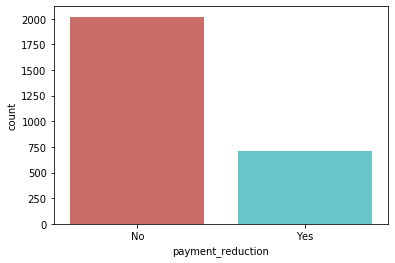

In [27]:
sns.countplot(x="payment_reduction",data = medicare_df,palette="hls")
plt.show()
#it seems to be skewed

#### 5) Training the model with Logistic Regression 

In [28]:
#splitting medicare_df into train and test samples
X_train, X_test, y_train, y_test = train_test_split(medicare_df.drop('payment_reduction',axis=1),medicare_df['payment_reduction'], test_size=0.30,random_state=101)

In [29]:
#training Logistic Regression model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
#predicting test values
predictions = logmodel.predict(X_test)

#### 6) Evaluating model performance

In [30]:
print(classification_report(y_test,predictions))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_test, predictions)))
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

              precision    recall  f1-score   support

          No       0.77      1.00      0.87       631
         Yes       0.00      0.00      0.00       188

    accuracy                           0.77       819
   macro avg       0.39      0.50      0.44       819
weighted avg       0.59      0.77      0.67       819

Accuracy of logistic regression classifier on test set: 0.77
[[631   0]
 [188   0]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### the model is unable to predict "yes" class

#### 7) Improving model performance

In [31]:
#generating % of bias in sample
count_no_pay = len(medicare_df[medicare_df["payment_reduction"]=="No"])
count_pay = len(medicare_df[medicare_df["payment_reduction"]=="Yes"])
pct_of_no_pay = count_no_pay/(count_no_pay+count_pay)
print("percentage of no payment reduction is", pct_of_no_pay*100)
pct_of_pay = count_pay/(count_no_pay+count_pay)
print("percentage of payment reduction", pct_of_pay*100)

percentage of no payment reduction is 74.01978746793696
percentage of payment reduction 25.980212532063028


#### up-sampling the payment reduction using the SMOTE algorithm(Synthetic Minority Oversampling Technique)

In [32]:

x = abs(medicare_df.loc[:, medicare_df.columns != "payment_reduction"])
y = medicare_df.loc[:, medicare_df.columns == "payment_reduction"]


In [33]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = X_train.columns




In [34]:
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns )
os_data_y = pd.DataFrame(data = os_data_y, columns = ["payment_reduction"])

In [35]:

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no payment in oversampled data",len(os_data_y[os_data_y["payment_reduction"]=="No"]))
print("Number of payment",len(os_data_y[os_data_y["payment_reduction"]=="Yes"]))
print("Proportion of no payment data in oversampled data is ",len(os_data_y[os_data_y["payment_reduction"]=="No"])/len(os_data_X))
print("Proportion of payment data in oversampled data is ",len(os_data_y[os_data_y["payment_reduction"]=="Yes"])/len(os_data_X))

length of oversampled data is  2852
Number of no payment in oversampled data 1426
Number of payment 1426
Proportion of no payment data in oversampled data is  0.5
Proportion of payment data in oversampled data is  0.5


####  using Recursive Feature Elimination (RFE) to repeatedly construct a model and choose either the best or worst performing feature


In [36]:
medicare_df_vars=medicare_df.columns.values.tolist()
y=["payment_reduction"]
X=[i for i in medicare_df_vars if i not in y]


In [37]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1]


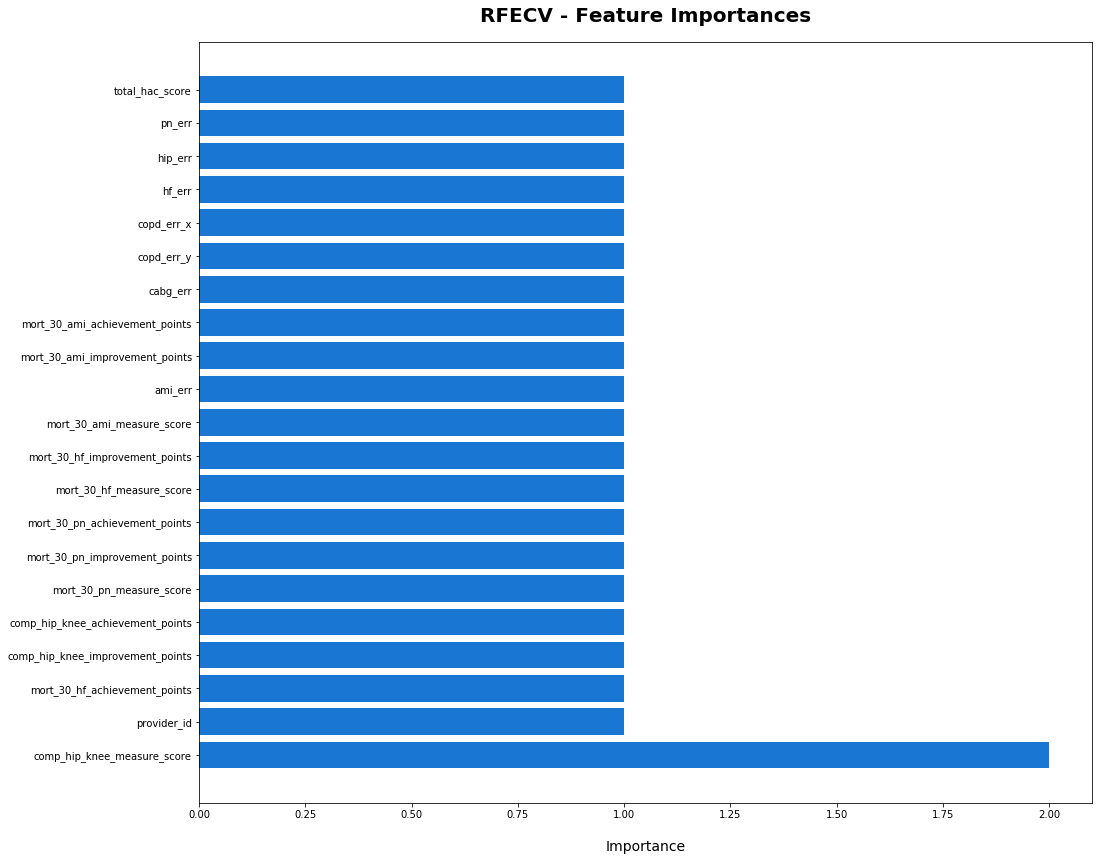

In [38]:
dset = pd.DataFrame()
dset["attr"] = x.columns
dset["importance"] = rfe.ranking_

dset = dset.sort_values(by="importance", ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset["attr"], width=dset["importance"], color="#1976D2")
plt.title("RFECV - Feature Importances", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("Importance", fontsize=14, labelpad=20)
plt.show()

#### comp_hip_knee_measure_score has the highest potential for predicting payment reduction

In [39]:
cols=["comp_hip_knee_measure_score","ami_err","total_hac_score"] 
x=os_data_X[cols]
y=os_data_y["payment_reduction"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


In [57]:
print(classification_report(y_test,y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.66      0.72      0.69       419
         Yes       0.71      0.64      0.67       437

    accuracy                           0.68       856
   macro avg       0.68      0.68      0.68       856
weighted avg       0.68      0.68      0.68       856

Accuracy: 0.6822429906542056


### Although overall accuracy of model has decreased, it has a better recall and f1-score as well as precision for "Yes" class which was biased.